In [1]:
import numpy as np
import pandas as pd
import numpy.random as rgt
from conquer.conquer.linear import low_dim, high_dim
#from selectinf.regreg_QR.QR_low_dim import low_dim
#from selectinf.regreg_QR.QR_high_dim import high_dim
from QR.selectinf.base import selected_targets
from QR.selectinf.QR_lasso import QR_lasso
from QR.selectinf.QR_lasso import QR_scad
from QR.selectinf.QR_lasso import QR_mcp
from QR.selectinf.randomization import randomization
from QR.selectinf.exact_reference import exact_grid_inference
from QR.selectinf.regreg_QR.QR_population import *
import matplotlib.pyplot as plt


def cov_generate(std, rho):
    p = len(std)
    R = np.abs(np.subtract.outer(np.arange(p), np.arange(p)))
    return np.outer(std, std) * (rho ** R)

def sensitivity_calculate(selected_set, nonzero_set, zero_set):
    selected = np.zeros(p)
    selected[selected_set] = 1
    Ture_positive = np.size([element for element in np.where(selected != 0)[0] if element in nonzero_set])
    False_positive = np.size([element for element in np.where(selected != 0)[0] if element in zero_set])
    False_negative = np.size([element for element in np.where(selected == 0)[0] if element in nonzero_set])
    return Ture_positive / (Ture_positive + 0.5 * False_positive + 0.5 * False_negative)


In [12]:
tau = 0.7 #tau-th population conditional quantile of y given x
n, p = 800, 201
mu, Sig = np.zeros(p - 1), cov_generate(np.ones(p - 1), 0.5)
gamma = np.zeros(p - 1)
gamma[0:5] = 0.1
# model setting
reps = 100
tau = 0.7 #tau-th population conditional quantile of y given x
n, p = 800, 201
mu, Sig = np.zeros(p - 1), cov_generate(np.ones(p - 1), 0.5)
gamma = np.zeros(p - 1)
gamma[0:5] = 0.1

X_tilde = rgt.multivariate_normal(mean=mu, cov=Sig, size=n)
Y = 0.2 + X_tilde.dot(gamma) + rgt.normal(loc=0, scale=2, size=n)
X = np.c_[np.ones(n), X_tilde] 
# true beta set
beta = np.append(0.2 + norm.ppf(tau, loc=0, scale=2), gamma)
nonzero_set = np.nonzero(beta)[0]
zero_set = np.array([i for i in range(p) if i not in nonzero_set])
    
randomizer = randomization.isotropic_gaussian(shape=(p,),
                                                 scale=(1 / np.sqrt(n)))

In [16]:
gamma = np.zeros(p - 1)
gamma[0:5] = 1
X_tilde = rgt.multivariate_normal(mean=mu, cov=Sig, size=n)
Y = 0.2 + X_tilde.dot(gamma) + rgt.normal(loc=0, scale=2, size=n)
X = np.c_[np.ones(n), X_tilde] 
# true beta set
beta = np.append(0.2 + norm.ppf(tau, loc=0, scale=2), gamma)
nonzero_set = np.nonzero(beta)[0]
zero_set = np.array([i for i in range(p) if i not in nonzero_set])
randomizer = randomization.isotropic_gaussian(shape=(p,),
                                                  scale=(1 / np.sqrt(n)))
conv = QR_scad(X,
                    Y,
                    tau=tau,
                    kernel="Gaussian",
                    randomizer=randomizer,
                    Lambda= 0.6 * np.sqrt(np.log(p) / n))
conv.fit()
conv.setup_inference()
query_spec = conv.specification
target_spec, _ = selected_targets(X,
                                      Y,
                                      tau=tau,
                                      solution=conv.observed_soln) #return unpenalized problem beta, Sigma, J_{EE^{-1} and alternatives 

    # nonzero set of penalized estimator
selected_set = np.nonzero(conv.observed_soln)[0]
selected_size = len(selected_set)

/Users/judydw/Documents/UMich/Research/Selective Inference/SQR/QR-Selectinf-main/QR/selectinf/regreg_QR/QR_high_dim_penalties.py:218: UserWarning: Maximum number of iterations achieved with Lambda=0.0 and tau=0.7
  warnings.warn("Maximum number of iterations achieved with Lambda={} and tau={}".format(Lambda[0], tau))


28


In [17]:
selected_size

82

In [7]:
conv = QR_scad(X,
                    Y,
                    tau=tau,
                    randomizer=randomizer,
                    Lambda=0.6 * np.sqrt(np.log(p) / n))
conv.fit()
conv.setup_inference()
query_spec = conv.specification
target_spec, _ = selected_targets(X,
                                      Y,
                                      tau=tau,
                                      solution=conv.observed_soln) #return unpenalized problem beta, Sigma, J_{EE^{-1} and alternatives 

from QR.selectinf.base import target_query_Interactspec
QS = query_spec
TS = target_spec
U1, U2, U3, U4, U5 = target_query_Interactspec(QS,
                                                       TS.regress_target_score,
                                                       TS.cov_target)
prec_target = np.linalg.inv(TS.cov_target)

prec_target_nosel = prec_target + U2 - U3 #sigma^j ?

_P = -(U1.T.dot(QS.M1.dot(QS.observed_score)) + U2.dot(TS.observed_target))

bias_target = TS.cov_target.dot(U1.T.dot(-U4.dot(TS.observed_target)
                                                 + QS.M1.dot(QS.opt_linear.dot(QS.cond_mean))) - _P)

cond_precision = np.linalg.inv(QS.cond_cov)
conjugate_arg = cond_precision.dot(QS.cond_mean)

precision = cond_precision
feasible_point = QS.observed_soln
con_linear =  QS.linear_part
con_offset = QS.offset
step = 1
nstep = 100
min_its = 200
tol = 1e-10
scaling = np.sqrt(np.diag(con_linear.dot(precision).dot(con_linear.T)))
scaling

KeyboardInterrupt: 

In [31]:
cov_rand, prec = randomizer.cov_prec
QS.opt_linear.T.dot((QS.opt_linear)) * prec

array([[ 22.48556088,   4.4925278 ,  -0.27019427, ...,   0.17375103,
        -12.83383597,  -1.37089872],
       [  4.4925278 ,  22.1882123 , -11.60638867, ...,   7.29109736,
         -1.0050367 ,  -2.69682939],
       [ -0.27019427, -11.60638867,  22.89649323, ...,  -2.77363161,
         -6.2953756 ,  11.24850388],
       ...,
       [  0.17375103,   7.29109736,  -2.77363161, ...,  17.16218894,
         -2.46597302,  -3.04115345],
       [-12.83383597,  -1.0050367 ,  -6.2953756 , ...,  -2.46597302,
         35.41971723,  -6.69983022],
       [ -1.37089872,  -2.69682939,  11.24850388, ...,  -3.04115345,
         -6.69983022,  18.1704451 ]])

In [24]:
QS.opt_linear.dot(QS.opt_linear.T)

array([[ 0.01007152, -0.00379152,  0.00111774, ...,  0.00517403,
        -0.0013408 , -0.00184705],
       [-0.00379152,  0.02421452,  0.00688122, ..., -0.00686451,
        -0.00183544, -0.00160591],
       [ 0.00111774,  0.00688122,  0.00988427, ..., -0.00039535,
        -0.00027087, -0.00040278],
       ...,
       [ 0.00517403, -0.00686451, -0.00039535, ...,  0.01560114,
         0.00801514,  0.0039199 ],
       [-0.0013408 , -0.00183544, -0.00027087, ...,  0.00801514,
         0.01123039,  0.00685447],
       [-0.00184705, -0.00160591, -0.00040278, ...,  0.0039199 ,
         0.00685447,  0.01051631]])

In [7]:
# set random seed
np.random.seed(2023)

# model setting 
tau = 0.7 #tau-th population conditional quantile of y given x
n, p = 800, 201
mu, Sig = np.zeros(p - 1), cov_generate(np.ones(p - 1), 0.5)
gamma = np.zeros(p - 1)
gamma[0:5] = 0.1
# model setting
reps = 300
tau = 0.7 #tau-th population conditional quantile of y given x
n, p = 800, 201
mu, Sig = np.zeros(p - 1), cov_generate(np.ones(p - 1), 0.5)
gamma = np.zeros(p - 1)
gamma[0:5] = 10

# record the results
coverage_naive = []
coverage_split = []
coverage_exact_lasso = []
coverage_exact_scad = []
coverage_exact_mcp = []

length_naive = []
length_split = []
length_exact_lasso = []
length_exact_scad = []
length_exact_mcp = []

F1_select_exact_lasso = []
F1_infere_exact_lasso = []
F1_select_exact_scad = []
F1_infere_exact_scad = []
F1_select_exact_mcp = []
F1_infere_exact_mcp = []




In [8]:

# selection
for i in range(reps):
    if i % 10 == 0:
        print('Current Iteration: ', i)
    
    X_tilde = rgt.multivariate_normal(mean=mu, cov=Sig, size=n)
    Y = 0.2 + X_tilde.dot(gamma) + rgt.normal(loc=0, scale=2, size=n)
    X = np.c_[np.ones(n), X_tilde] 
    # true beta set
    beta = np.append(0.2 + norm.ppf(tau, loc=0, scale=2), gamma)
    nonzero_set = np.nonzero(beta)[0]
    zero_set = np.array([i for i in range(p) if i not in nonzero_set])
    
    randomizer = randomization.isotropic_gaussian(shape=(p,),
                                                  scale=(1 / np.sqrt(n)))
    conv = QR_lasso(X,
                    Y,
                    tau=tau,
                    randomizer=randomizer,
                    Lambda=1.2 * np.sqrt(np.log(p) / n))
    conv.fit()
    conv.setup_inference()
    query_spec = conv.specification
    target_spec, _ = selected_targets(X,
                                      Y,
                                      tau=tau,
                                      solution=conv.observed_soln) #return unpenalized problem beta, Sigma, J_{EE^{-1} and alternatives 

    # nonzero set of penalized estimator
    selected_set = np.nonzero(conv.observed_soln)[0]
    selected_size = len(selected_set)
    
    if selected_size != 0:
        # inference
        exact_grid_inf = exact_grid_inference(query_spec, target_spec)

        # confidence interval
        beta_target = np.linalg.pinv(X[:, selected_set]).dot(X.dot(beta))  # target
        lci, uci = exact_grid_inf._intervals(level=0.90)

        # coverage
        coverage = (lci < beta_target) * (uci > beta_target)
        coverage_exact_lasso.append(np.mean(coverage))

        # length
        length = uci - lci
        length_exact_lasso.append(np.mean(length))

        # F1 score base on selection
        F1_select = sensitivity_calculate(selected_set, nonzero_set, zero_set)
        F1_select_exact_lasso.append(F1_select)

        # F1 score base on inference
        selected_infere = np.zeros(p)
        selected_infere[selected_set] = (lci > 0) | (uci < 0)
        F1_infere = sensitivity_calculate(np.nonzero(selected_infere)[0], nonzero_set, zero_set)
        F1_infere_exact_lasso.append(F1_infere)

    randomizer = randomization.isotropic_gaussian(shape=(p,),
                                                  scale=(1 / np.sqrt(n)))
    conv = QR_scad(X,
                    Y,
                    tau=tau,
                    randomizer=randomizer,
                    Lambda=1.2 * np.sqrt(np.log(p) / n))
    conv.fit()
    conv.setup_inference()
    query_spec = conv.specification
    target_spec, _ = selected_targets(X,
                                      Y,
                                      tau=tau,
                                      solution=conv.observed_soln) #return unpenalized problem beta, Sigma, J_{EE^{-1} and alternatives 

    # nonzero set of penalized estimator
    selected_set = np.nonzero(conv.observed_soln)[0]
    selected_size = len(selected_set)
    
    if selected_size != 0:
        # inference
        exact_grid_inf = exact_grid_inference(query_spec, target_spec)

        # confidence interval
        beta_target = np.linalg.pinv(X[:, selected_set]).dot(X.dot(beta))  # target
        lci, uci = exact_grid_inf._intervals(level=0.90)

        # coverage
        coverage = (lci < beta_target) * (uci > beta_target)
        coverage_exact_scad.append(np.mean(coverage))

        # length
        length = uci - lci
        length_exact_scad.append(np.mean(length))

        # F1 score base on selection
        F1_select = sensitivity_calculate(selected_set, nonzero_set, zero_set)
        F1_select_exact_scad.append(F1_select)

        # F1 score base on inference
        selected_infere = np.zeros(p)
        selected_infere[selected_set] = (lci > 0) | (uci < 0)
        F1_infere = sensitivity_calculate(np.nonzero(selected_infere)[0], nonzero_set, zero_set)
        F1_infere_exact_scad.append(F1_infere)
        
    randomizer = randomization.isotropic_gaussian(shape=(p,),
                                                  scale=(1 / np.sqrt(n)))
    conv = QR_mcp(X,
                   Y,
                   tau=tau,
                   randomizer=randomizer,
                   Lambda=1.2 * np.sqrt(np.log(p) / n))
    conv.fit()
    conv.setup_inference()
    query_spec = conv.specification
    target_spec, _ = selected_targets(X,
                                      Y,
                                      tau=tau,
                                      solution=conv.observed_soln)  # return unpenalized problem beta, Sigma, J_{EE^{-1} and alternatives

    # nonzero set of penalized estimator
    selected_set = np.nonzero(conv.observed_soln)[0]
    selected_size = len(selected_set)

    if selected_size != 0:
        # inference
        exact_grid_inf = exact_grid_inference(query_spec, target_spec)

        # confidence interval
        beta_target = np.linalg.pinv(X[:, selected_set]).dot(X.dot(beta))  # target
        lci, uci = exact_grid_inf._intervals(level=0.90)

        # coverage
        coverage = (lci < beta_target) * (uci > beta_target)
        coverage_exact_mcp.append(np.mean(coverage))

        # length
        length = uci - lci
        length_exact_mcp.append(np.mean(length))

        # F1 score base on selection
        F1_select = sensitivity_calculate(selected_set, nonzero_set, zero_set)
        F1_select_exact_mcp.append(F1_select)

        # F1 score base on inference
        selected_infere = np.zeros(p)
        selected_infere[selected_set] = (lci > 0) | (uci < 0)
        F1_infere = sensitivity_calculate(np.nonzero(selected_infere)[0], nonzero_set, zero_set)
        F1_infere_exact_mcp.append(F1_infere)

Current Iteration:  0
6
9
13
8
11
7
8
7
8
11
9
10
11
10
9
8
8
7
7
7
7
7
9
12
8
6
8
9
8
7
Current Iteration:  10
8
8
9
9
6
11
11
6
7
8
7
9
11
7
7
7
8
7
13
9
6
9
7
6
11
6
7
7
9
8
Current Iteration:  20
12
8
9
11
7
7
10
9
10
8
8
10
10
8
8
8
7
9
11
7
10
7
10
13
9
8
10
11
9
7
Current Iteration:  30
8
10
7
8
9
11
8
8
8
6
7
10
9
8
10
10
11
8
9
9
8
7
9
9
8
8
7
7
8
12
Current Iteration:  40
10
8
11
7
9
6
9
10
8
8
10
11
9


/Users/judydw/Documents/UMich/Research/Selective Inference/SQR/QR-Selectinf-main/QR/selectinf/Utils/discrete_family.py:127: RuntimeWarning: overflow encountered in exp
  self._partition *= np.exp(_largest)
/Users/judydw/Documents/UMich/Research/Selective Inference/SQR/QR-Selectinf-main/QR/selectinf/Utils/discrete_family.py:127: RuntimeWarning: overflow encountered in scalar multiply
  self._partition *= np.exp(_largest)


11
11
11
6
15
10
8
6
12
8
11
11
8
6
12
6
8
Current Iteration:  50
11
8
8
9
10
10
6
9
8
8
8
9
7
10
8
9
8
12
8
6
10
9
8
7
10
9


/Users/judydw/Documents/UMich/Research/Selective Inference/SQR/QR-Selectinf-main/QR/selectinf/regreg_QR/QR_high_dim_penalties.py:218: UserWarning: Maximum number of iterations achieved with Lambda=0.0 and tau=0.7
  warnings.warn("Maximum number of iterations achieved with Lambda={} and tau={}".format(Lambda[0], tau))


15
8
7
14
Current Iteration:  60
8
6
8
7
9
9
7
10
7
9
9
8
7
8
8
10
10
13
11
9
7
8
9
11
8
10
10
8
7
8
Current Iteration:  70
9
8
8
8
8
7
9
9
8
9
8
8
11
8
7
7
8
9
7
8
8
8
7
6
8
10
11
7
10
12
Current Iteration:  80
8
8
8
11
8
11
8
8
7
9
8
11
9
9
9
9
10
9
10
9
9
7
8
7
8
8
9
13
6
12
Current Iteration:  90
9
9
8
6
7
8
8
9
9
11
10
11
9
9
7
11
10
9
7
10
11
9
10
9
10
7
7
7
8
9
Current Iteration:  100
9
7
11
8
8
6
9
8
6
10
10
7
7
8
9
9
8
8
8
9
9
11
8
11
8
10
9
10
11
10
Current Iteration:  110
9
8
10
7
7
7
11
8
9
9
7
10
7
7
8
9
9
7
12
8
9
9
6
11
7
9
6
8
9
8
Current Iteration:  120
8
9
11
6
8
9
7
7
9
10
10
14
10
9
9
7
9
13
11
8
8
7
7
6
7
7
12
9
7
8
Current Iteration:  130
7
6
9
9
9
8
8
8
15
9
8
10
9
9
12
9
8
6
8
9
8
8
7
8
11
7
8
9
11
9
Current Iteration:  140
7
8
11
7
11
8
11
6
12
7
10
8
8
8
7
9
10
9
9
7
13
9
12
8
9
6
8
7
9
9
Current Iteration:  150
10
9
6
8
9
7
7
8
9
9
13
6
11
9
10
9
9
8
11
7
9
6
6
8
8
11
12


/Users/judydw/Documents/UMich/Research/Selective Inference/SQR/QR-Selectinf-main/QR/selectinf/Utils/discrete_family.py:127: RuntimeWarning: overflow encountered in exp
  self._partition *= np.exp(_largest)


8
11
8
Current Iteration:  160
9
6
9
8
9
15
10
8
8
9
11
6
9
7
11
8
9
10
8
8
7
9
11
11
7
7
7
6
11
11
Current Iteration:  170
8
7
8
9
9
9
7
8
8
7
8
8
7
10
8
7
10
12
9
10
8
6
7
9
10
6
10
11
9
11
Current Iteration:  180
7
6
10
6
7
7
7
9
9
8
10
8
8
8
11
8
9
8
9
7
7
9
6
6
7
10
8
8
9
10
Current Iteration:  190
8
7
8
8
7
11
8
9
11
10
8
9
6
7
10
9
8
9
12
10
8
10
9
6
8
10
9
9
6
7
Current Iteration:  200
8
8
10
6
9
10
7
8
6
6
7
7
8
7
8
9
7
7
8
8
11
10
6
9
9
12
8
8
9
11
Current Iteration:  210
8
9
11
8
9
10
13
7
6
10
9
10
8
10
9
9
7
9
11
10
7
7
10
9
7
6
8
11
9
9
Current Iteration:  220
9
10
12
13
9
10
8
8
7
8
9
10
8
9
11
8
10
8
10
13
8
10
9
7
10
6
8
8
12
8
Current Iteration:  230
7
9
14
11
7
8
8
6
6
9
10
9
10
9
10
11
9
12
8
9
8
11
7
9
9
8
9
7
9
9
Current Iteration:  240
8
8
9
11
7
8
7
9
8
9
6
11
8
9
7
6
7
9
9
8
8
9
7
9
9
11
9
8
7
8
Current Iteration:  250
8
8
10
7
9
6
8
7
10
11
10
11
7
7
7
9
10
8
11
7
11
10
13
8
11
9
11
11
8
9
Current Iteration:  260
13
14
7
9
13
10
7
10
7
9
7
9
11
10
9
13
9
6
12


/Users/judydw/Documents/UMich/Research/Selective Inference/SQR/QR-Selectinf-main/QR/selectinf/Utils/discrete_family.py:127: RuntimeWarning: overflow encountered in exp
  self._partition *= np.exp(_largest)


8
10
8
8
11
7
6
7
10
8
12
7
11
7
9
8
8
11
8
11
9
6
8
8
6
8
Current Iteration:  280
13
8
10
8
7
9
8
12
8
9
6
7
7
7
8
9
10
7
7
7
11
7
10
8
9
10
8
11
11
8
Current Iteration:  290
9
8
11
11
8
9
9
9
11
11
9
11
9
8
10
12
7
8
6
7
7
8
8
9
8
8
8
6
10
7


In [9]:
print(np.mean(coverage_exact_scad))
print(np.mean(coverage_exact_mcp))

0.886451011951012
0.880431216931217


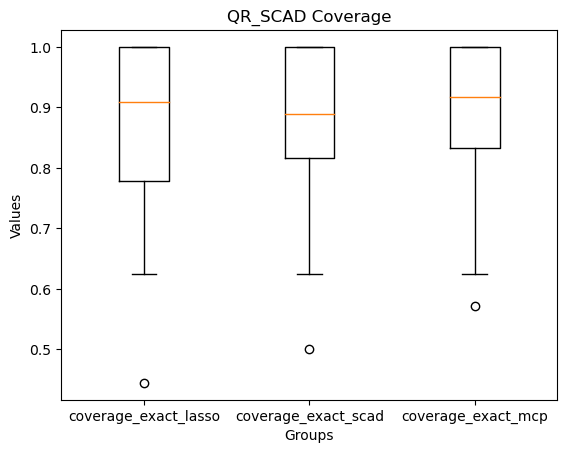

In [11]:
import matplotlib.pyplot as plt
coverage = pd.DataFrame({
    'coverage_exact_lasso': coverage_exact_lasso[:55],
    'coverage_exact_scad': coverage_exact_scad[:55],
    'coverage_exact_mcp': coverage_exact_mcp[:55]
})
plt.boxplot(coverage.values, labels=coverage.columns)

# Add titles and labels
plt.title('QR_SCAD Coverage')
plt.xlabel('Groups')
plt.ylabel('Values')


# Show the plot
plt.show()

In [5]:
np.random.seed(2023)

# model setting 
reps=500
tau = 0.7 #tau-th population conditional quantile of y given x
n, p = 800, 201
mu, Sig = np.zeros(p - 1), cov_generate(np.ones(p - 1), 0.5)
gamma = np.zeros(p - 1)
gamma[0:5] = 5


# record the results
coverage_naive = []
coverage_split = []
coverage_exact_lasso = []
coverage_exact_scad = []
coverage_exact_mcp = []

length_naive = []
length_split = []
length_exact_lasso = []
length_exact_scad = []
length_exact_mcp = []

F1_select_exact_lasso = []
F1_infere_exact_lasso = []
F1_select_exact_scad = []
F1_infere_exact_scad = []
F1_select_exact_mcp = []
F1_infere_exact_mcp = []

# selection
for i in range(reps):
    if i % 10 == 0:
        print('Current iteration: ',i)
    
    X_tilde = rgt.multivariate_normal(mean=mu, cov=Sig, size=n)
    Y = 0.2 + X_tilde.dot(gamma) + rgt.normal(loc=0, scale=2, size=n)
    X = np.c_[np.ones(n), X_tilde] 
    # true beta set
    beta = np.append(0.2 + norm.ppf(tau, loc=0, scale=2), gamma)
    nonzero_set = np.nonzero(beta)[0]
    zero_set = np.array([i for i in range(p) if i not in nonzero_set])
    
    randomizer = randomization.isotropic_gaussian(shape=(p,),
                                                  scale=(1 / np.sqrt(n)))
    conv = QR_mcp(X,
                    Y,
                    tau=tau,
                    randomizer=randomizer,
                    Lambda=1.2 * np.sqrt(np.log(p) / n))
    conv.fit()
    conv.setup_inference()
    query_spec = conv.specification
    target_spec, _ = selected_targets(X,
                                      Y,
                                      tau=tau,
                                      solution=conv.observed_soln) #return unpenalized problem beta, Sigma, J_{EE^{-1} and alternatives 

    # nonzero set of penalized estimator
    selected_set = np.nonzero(conv.observed_soln)[0]
    selected_size = len(selected_set)
    if selected_size != 0:
        # inference
        exact_grid_inf = exact_grid_inference(query_spec, target_spec)

        # confidence interval
        beta_target = np.linalg.pinv(X[:, selected_set]).dot(X.dot(beta))  # target
        lci, uci = exact_grid_inf._intervals(level=0.90)

        # coverage
        coverage = (lci < beta_target) * (uci > beta_target)
        coverage_exact_mcp.append(np.mean(coverage))

        # length
        length = uci - lci
        length_exact_mcp.append(np.mean(length))

        # F1 score base on selection
        F1_select = sensitivity_calculate(selected_set, nonzero_set, zero_set)
        F1_select_exact_mcp.append(F1_select)

        # F1 score base on inference
        selected_infere = np.zeros(p)
        selected_infere[selected_set] = (lci > 0) | (uci < 0)
        F1_infere = sensitivity_calculate(np.nonzero(selected_infere)[0], nonzero_set, zero_set)
        F1_infere_exact_mcp.append(F1_infere)


Current iteration:  0


KeyboardInterrupt: 

In [3]:
np.mean(coverage_exact_mcp)

0.8691343378843378

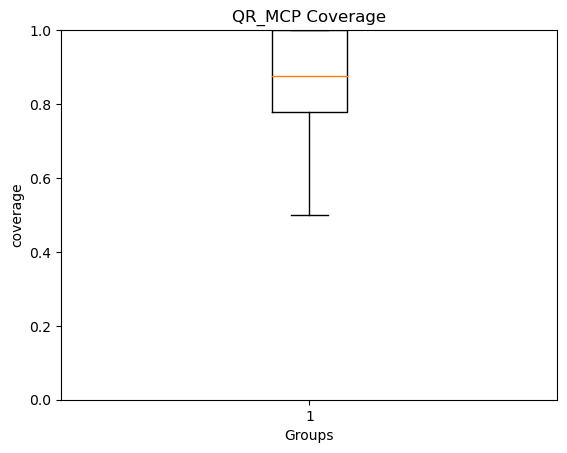

In [4]:
plt.boxplot(coverage_exact_mcp)

# Add titles and labels
plt.title('QR_MCP Coverage')
plt.xlabel('Groups')
plt.ylabel('coverage')
plt.ylim(0,1.0)

# Show the plot
plt.show()

In [21]:
np.diag(query_spec.opt_linear.T.dot(query_spec.opt_linear))

array([0.02066412, 0.01164429, 0.03135309, 0.04839293, 0.01771198,
       0.01642161, 0.00990483, 0.01193779, 0.03804599, 0.02825426,
       0.01693266, 0.01362253, 0.01614537, 0.0196321 , 0.034461  ,
       0.01229136, 0.02578913, 0.00673602, 0.00944922, 0.02315326,
       0.01623501, 0.0292818 , 0.02042477, 0.01876758, 0.01790938,
       0.03609122, 0.01429125, 0.02291308, 0.01658285, 0.02438762,
       0.0032399 , 0.01857497, 0.04996742, 0.02810442, 0.01472615,
       0.02631679, 0.02746994, 0.02429875, 0.0354097 , 0.00869106,
       0.02819589, 0.0297402 , 0.01321069, 0.0153946 , 0.01983582,
       0.01932532, 0.05363856, 0.05415856, 0.01481623, 0.01496238,
       0.02256543, 0.00747845, 0.01819341, 0.02202062, 0.01988851,
       0.02162493, 0.02172381, 0.01194336, 0.01670248, 0.03253693,
       0.01405329, 0.01410635, 0.01734166, 0.02684396, 0.01089457,
       0.01541283, 0.02602416, 0.01775956, 0.01713455, 0.01533115,
       0.002471  , 0.01296455, 0.00399664, 0.01684812, 0.03899

In [5]:
from QR.selectinf.base import target_query_Interactspec
QS = query_spec
TS = target_spec
U1, U2, U3, U4, U5 = target_query_Interactspec(QS,
                                                       TS.regress_target_score,
                                                       TS.cov_target)
prec_target = np.linalg.inv(TS.cov_target)

prec_target_nosel = prec_target + U2 - U3 #sigma^j ?


_P = -(U1.T.dot(QS.M1.dot(QS.observed_score)) + U2.dot(TS.observed_target))

bias_target = TS.cov_target.dot(U1.T.dot(-U4.dot(TS.observed_target)
                                                 + QS.M1.dot(QS.opt_linear.dot(QS.cond_mean))) - _P)

cond_precision = np.linalg.inv(QS.cond_cov)
conjugate_arg = cond_precision.dot(QS.cond_mean)

In [6]:
precision = cond_precision
feasible_point = QS.observed_soln
con_linear =  QS.linear_part
con_offset = QS.offset
step = 1
nstep = 100
min_its = 200
tol = 1e-10



In [7]:
np.diag(query_spec.cond_cov)

array([-2.08205481e+14,  5.15778787e+13, -1.17770543e+14, -1.41520636e+13,
       -2.79160690e+14, -6.34781000e+14, -5.31759518e+13,  1.31339267e+14,
        1.65639224e+14, -1.23761256e+14,  2.43780967e+13,  7.50139468e+12,
       -3.70567483e+14, -2.77094584e+14, -1.51389225e+14, -3.43795683e+12,
        2.55046189e+14, -5.58558845e+13, -7.67549993e+14, -3.62984359e+13,
       -6.21058720e+14,  2.41313338e+13,  2.07440280e+14,  6.12071176e+13,
       -8.35802478e+13,  4.37787491e+13,  5.68672111e+13, -8.16252948e+13,
       -8.55102765e+13, -4.98860763e+14, -2.86586542e+13,  4.33036383e+14,
       -1.39706704e+14,  1.48428280e+14, -1.58930407e+14,  5.30855479e+13,
       -4.16849189e+14, -3.88671911e+13, -6.96376354e+14, -1.85309561e+14,
        6.36873308e+13,  4.17105483e+13, -1.95387492e+14, -5.71965862e+12,
       -9.69242060e+13, -1.88507832e+14, -5.87936728e+13, -8.14621039e+12,
        7.48564245e+14, -3.80222287e+13, -1.59602408e+13, -4.72502942e+13,
        1.27987299e+13, -

In [ ]:
np.diag(con_linear.dot(precision).dot(con_linear.T))

In [24]:
scaling = np.sqrt(np.diag(con_linear.dot(precision).dot(con_linear.T)))
scaling

/var/folders/p_/wj4jvr5929x__hfp1fb3gy400000gs/T/ipykernel_60108/1325844155.py:1: RuntimeWarning: invalid value encountered in sqrt
  scaling = np.sqrt(np.diag(con_linear.dot(precision).dot(con_linear.T)))


array([6.20457873, 2.18320757, 0.64887657,        nan,        nan,
       2.35136353,        nan, 2.61695933, 7.57031321,        nan,
       3.92981566,        nan, 5.40801079, 4.54090696, 2.25926   ,
       4.10353487, 3.19060446, 3.45473846,        nan, 1.64571951,
       0.67081224,        nan, 4.86242782, 8.18011295,        nan,
              nan, 5.72539884, 8.4156822 , 8.56567654,        nan,
       7.13464199, 1.75756434, 6.00053473,        nan,        nan,
              nan, 1.44747219, 8.50359642,        nan,        nan,
       6.74048859,        nan, 0.701964  ,        nan, 1.78439936,
              nan, 6.80579725,        nan, 8.91086242, 4.01795404,
       1.77457314, 1.51555019,        nan,        nan,        nan,
              nan, 6.39803632,        nan,        nan, 1.91907079,
              nan,        nan,        nan,        nan, 4.17691026,
              nan,        nan, 2.83592775, 1.25983121,        nan,
              nan, 0.91154867, 4.02779558, 1.25380908,        

In [33]:
cov_rand, prec = randomizer.cov_prec
if np.asarray(prec).shape in [(), (0,)]:
    cond_precision = linear.T.dot(linear) * prec
    cond_cov = np.linalg.inv(cond_precision)
    regress_opt = -cond_cov.dot(linear.T) * prec
else:
    cond_precision = linear.T.dot(prec.dot(linear))
    cond_cov = np.linalg.inv(cond_precision)
    regress_opt = -cond_cov.dot(linear.T).dot(prec)

In [43]:
randomizer.cov_prec

(0.00125, 800.0)

In [25]:
objective = lambda u: -u.T.dot(conjugate_arg) + u.T.dot(precision).dot(u)/2. \
                          + np.log(1.+ 1./((con_offset - con_linear.dot(u))/ scaling)).sum()
grad = lambda u: -conjugate_arg + precision.dot(u) - con_linear.T.dot(1./(scaling + con_offset - con_linear.dot(u)) -
                                                                       1./(con_offset - con_linear.dot(u)))
barrier_hessian = lambda u: con_linear.T.dot(np.diag(-1./((scaling + con_offset-con_linear.dot(u))**2.)
                                                 + 1./((con_offset-con_linear.dot(u))**2.))).dot(con_linear)

In [26]:
current = feasible_point
current_value = -1000 

In [27]:
cur_grad = grad(current)